## Comparing two methods of IBD calculation for `forward-dream`

In this notebook I will compare two  different ways we can go about calculating identity-by-descent (IBD) within the `forward-dream`.

First note taking identity-by-state (IBS) to be IBD can result in a large amount of false positive signal, since IBS can occur due to the by-chance sharing of a common variant, jointly inherited from a distant ancestor; or by recurrent mutation; whereas for IBD we are typically talking about very recent common ancestry.

To compute IBD, one approach is to impose a simple length threshold on IBS. Long contiguous fragments of IBS are likely to be the result of a recent common ancestry, because they suggest that not enough time has passed for either recombiation or mutation to cause divergence over the segment. A matched allelic state over a long string of sites due to chance is unlikely.

Another approach is to construct a probabilistic model of IBD leveraging allele frequencies. Here, the transitions between states are dictated by the recombination rate, and the emission probability represent the likelihood of observing a given pair of alleles conditioned on the IBD state. The Viterbi path gives the most likely path through the hidden states, i.e. the IBD profile along the genome.

In [1]:
import os
import sys
import json

import pandas as pd
import numpy as np

from lib.data_collection import *

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn import metrics

%matplotlib inline
plt.rcParams["figure.dpi"] = 100

In [2]:
savefigs = False
output_dir = "../figs/review"

## Load data

In [3]:
expt_dir = "../results/2021-01-24_corr-04final-nv/"
sims = os.listdir(expt_dir)
print("No. simulations: %d" % len(sims))

No. simulations: 80


In [4]:
dt = {"id": [], "x_h": []}
for sim in sims:
    try:
        # Load epoch data
        epoch_df = pd.read_csv(os.path.join(expt_dir, sim, "epoch_df.csv"))
        x_h = round(epoch_df["x_h"][1], 2)
        
        # Store
        dt["id"].append(sim)
        dt["x_h"].append(x_h)
    except:
        print("Failed for %s" % sim)
sim_df = pd.DataFrame(dt)

Failed for sim_corr-04final_0004


In [5]:
# Select one at each prevalence level
keep = []
for s, sdf in sim_df.groupby("x_h"):
    keep.append(sdf.iloc[0]["id"])

In [6]:
len(keep)

8

In [7]:
h_data = {}
diags = []
for sim in keep:
    try:
        # Load genomes
        genomes = np.load(os.path.join(expt_dir, sim, "InitVar", "h_genomes.npy"))
        diag = json.load(open(os.path.join(expt_dir, sim, "run_diagnostics.json"), "r"))
        
        # Load epoch data
        epoch_df = pd.read_csv(os.path.join(expt_dir, sim, "epoch_df.csv"))
        x_h = round(epoch_df["x_h"][1], 2)
        
        # Store
        h_data[sim] = genomes
        diag.update({"x_h": x_h})
        diag.update({"id": sim})
        diags.append(diag)
    except:
        print("Failed for %s" % sim)

In [8]:
genomes.shape

(20, 4000, 813)

In [9]:
diagnostics_df = pd.DataFrame(diags)
diagnostics_df.sort_values("x_h", inplace=True)

In [10]:
diagnostics_df

,runtime,peak_mem_mb,extinct,x_h,id
0,0:04:42.703388,0.263868,False,0.1,sim_corr-04final_0006
1,0:14:31.382325,0.286096,False,0.2,sim_corr-04final_0014
2,1:00:40.785489,0.300684,False,0.3,sim_corr-04final_0030
3,1:14:01.967372,0.346092,False,0.4,sim_corr-04final_0039
4,3:48:42.394289,0.360976,False,0.5,sim_corr-04final_0052
5,5:36:11.285595,0.400912,False,0.6,sim_corr-04final_0063
6,7:36:56.123600,0.439892,False,0.7,sim_corr-04final_0064
7,22:23:03.814828,0.516556,False,0.8,sim_corr-04final_0078


## Implement HMM based method

In [11]:
genomes.shape

(20, 4000, 813)

In [12]:
# Instantiate class for function access
storage = DataCollection(prev_samp_freq=0, 
                         div_samp_freq=0, 
                         max_samples=None,
                         detection_threshold=0.01,
                         track_ibd=False)

In [13]:
# Sequence DNA of all the genomes
sequences = []
ixs = []
for i in range(genomes.shape[2]):
    k, sequence = storage.sequence_dna(genomes[:, :, i], detection_threshold=0.01)
    ixs.extend([i] * k)
    sequences.append(sequence)
sequences = np.vstack(sequences).T

In [14]:
# Steps for method
# 1. Get allele frequencies
# 2. Compute IBS between pair of strains
# 3. Create allele frequency vectors for each strain
# 4. Use the vectors and IBS to compute the emission probabilities

In [15]:
def calc_hmm_emission_probabilities(pair, af):
    """
    Given a `pair` of haplotypes and an allele
    frequencies matrix `af`, return the emission
    probabilities for an hidden Markov Model
    computing IBD
    
    If the random variable X encodes the IBD state,
    then X=0 is not IBD and X=1 is IBD.
    
    The allelic states are represented by Ai, i={1, ..., n},
    with population level frequencies of pi, i={1, ..., n}
    where a site can have `n` alleles.
    
    Then, the emission probabilities are:
    
    P(Ai, Ai | X=0) = pi^2           # Sample *two* same parental alleles
    P(Ai, Aj | X=0) = 2 * pi * pj    # Sample *two* dif parental alleles
    P(Ai, Ai | X=1) = pi             # Sample *one* parental allele
    P(Ai, Aj | X=1) = 0              # If dif, can't be IBD bc no error
    
    Parameters
        pairs : ndarray, int/float, shape (nsnps, 2)
            Carries two haplotypes as columns. Rows are
            the SNPs. Each element encodes an allelic state.
        af : ndarray, int, shape (nsnps, nalleles)
            The allele frequencies for each SNP.
            
    
    Returns
        emission_probs : ndarray, float, shape (nsnps, 2)
            Emission probabilities for the observed genotypes
            for a hidden state of not IBD (column 1) or IBD (column 2)
    
    """
    
    nsnps, _ = pair.shape
    
    # Compute IBS
    ibs = pair[:, 0] == pair[:, 1]
    
    # Compute af vectors for each haplotype
    af_vectors = np.zeros((nsnps, 2))
    z = np.arange(nsnps)
    af_vectors[:, 0] = af[z, pair[:, 0]]
    af_vectors[:, 1] = af[z, pair[:, 1]]
    
    # Prepare emission probability matrix
    # - These change for each site depending on the allele frequencies
    emission_probs = np.zeros((nsnps, 2))  # col 0: not IBD, col 1: IBD
    
    # Compute probability of genotype if not in IBD
    emission_probs[:, 0] = af_vectors.prod(1)
    emission_probs[:, 0][~ibs] *= 2 # if different, two sampling possibilities
    
    # Compute probability of genotype if in IBD
    emission_probs[:, 1][ibs] = af_vectors[:, 0][ibs]  # same for either pair
    
    return emission_probs

In [16]:
# Workflow
ac = allel.HaplotypeArray(sequences).count_alleles()
af = ac.to_frequencies()

pair = sequences[:, (0, 1)]
emiss = calc_hmm_emission_probabilities(pair, af)

## Sanity check visualisation

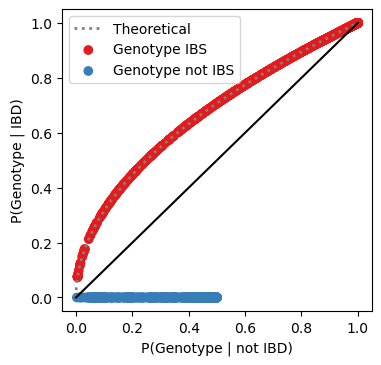

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ibs = pair[:, 0] == pair[:, 1]
ax.scatter(x=emiss[ibs, 0], 
           y=emiss[ibs, 1], 
           c=[sns.color_palette("Set1", 2)[0]]*ibs.sum(),
           label="Genotype IBS")
ax.scatter(x=emiss[~ibs, 0], 
           y=emiss[~ibs, 1], 
           c=[sns.color_palette("Set1", 2)[1]]*(~ibs).sum(),
           label="Genotype not IBS")

ps = np.linspace(0, 1, 100)
ax.plot(ps**2, ps, lw=2, ls='dotted', color='grey', label="Theoretical")

ax.plot([0, 1], [0, 1], color='black')
ax.set_xlabel("P(Genotype | not IBD)")
ax.set_ylabel("P(Genotype | IBD)")
ax.legend()

- We can see the probability of being in IBD is *always* higher if they share the same allele (are IBS)
    - This makes sense, if $0<p<1$ then $p^2 \leq p$
- If the genotype is not IBS, then by this definition it cannot by IBD, and the $P(Genotype|IBD)=0$

In [18]:
@jit(nopython=True)
def get_ibd_segments_hmm(rho, emiss):
    """
    Given an IBS profile for two parasite genomes,
    return a set of IBD tracks calculated using
    a simple hidden Markov Model

    Parameters
        ibs_state : ndarray, bool, shape (nsnps)
            For each position in the genome report,
            True if both parasite genomes carry the
            same allele.
        rho : float
            The recombination rate between sites.
            Assumed uniform across the genome.
        emiss : ndarray, float64, shape(2, 2)
            Numpy array containing the emission probabilities
            for the HMM.

    Returns
        ibd_segs : ndarray, float32, shape(n_ibd_segments)
            Numpy array containing the length of all the 
            IBD segments detected by the HMM.
    """

    # Parameters
    nsnps = emiss.shape[0]

    # Prepare data structures
    vt = emiss[0]  # initialise
    tb = np.zeros((2, nsnps), np.int8)  # states by sites
    tb[1, 1:] = 1
    wmx = vt.argmax()
    vt /= vt[wmx]
    vtn = vt * (1 - rho)

    # Iterate
    for j in range(1, nsnps):
        for i in range(2):
            if vt[i] * (1 - rho) < rho:
                vtn[i] = rho
                tb[i, j] = wmx
            else:
                vtn[i] = vt[i] * (1 - rho)
            vtn[i] *= emiss[j, i]
        wmx = vtn.argmax()
        vt = vtn / vtn[wmx]

    # Traceback to produce IBD segment list
    state = vt.argmax()
    l = state
    ibd_segs = []
    for j in range(2, nsnps):
        state = tb[state, nsnps-j]
        if state:
            l += 1
        elif l > 0:
            ibd_segs.append(l)
            l = 0
    if l > 0: 
        ibd_segs.append(l)  # append last segment

    return np.array(ibd_segs)

## Compare two methods

In [19]:
nsnps = sequences.shape[0]

In [20]:
# Set the IBD parameters
# - Want a detection threshold of 2cM
prob_rec_between_sites = 1 / (2 * nsnps)  # b/c one recombination per bivalent
n_meioses = 50  # for a 2cM track
rho = prob_rec_between_sites * n_meioses
length_threshold = 1 / rho

print("rho: %.03f" % rho)
print("length threshold: %.03f" % length_threshold)

rho: 0.006
length threshold: 160.000


In [21]:
pair = sequences[:, (0, 3)]
pair

array([[1, 0],
       [1, 1],
       [0, 0],
       ...,
       [0, 0],
       [1, 1],
       [0, 0]], dtype=int8)

In [22]:
# By HMM
emiss = calc_hmm_emission_probabilities(pair, af)
get_ibd_segments_hmm(rho, emiss)

array([68, 89])

In [23]:
# By IBS
ibs = pair[:, 0] == pair[:, 1]
get_ibs_segments(ibs)

array([16,  9,  8,  2,  5,  5, 66, 35,  5,  4, 20,  4, 16, 27,  1,  9,  8,
       11,  2, 15, 14,  2,  3, 13,  2,  6,  2, 15, 10,  7,  3,  7,  3,  9,
        4,  3, 11,  2, 24,  4,  1,  6,  8, 33,  5,  3,  2, 10, 17,  4,  5,
        5,  2,  9,  4,  9,  1,  2,  3,  1,  3,  3,  1,  3,  3,  2,  2,  1,
        3, 41,  1,  3,  7,  3,  3,  4,  1,  4,  1,  8,  2,  2, 17,  5,  8,
        1,  9, 11,  2,  2,  6,  2,  1,  3,  1,  9,  3,  5,  4,  9, 19, 18,
        2,  2,  5,  4,  1,  5,  1,  2,  5,  5,  2,  4,  2,  3, 39,  1,  3,
        1,  1,  1,  1,  1,  8, 16, 17, 35, 15,  1,  7,  9, 14,  1,  3, 11,
        6,  1,  9, 38,  7, 15, 18,  4,  5, 34,  1, 36,  1, 29,  8,  1,  1,
        3,  2,  1,  1,  9, 16, 28,  2,  4,  6,  7, 11,  4,  2, 12, 17,  7,
        1,  2, 13,  6,  5,  7,  6,  7, 10, 24,  3, 16,  2,  1,  5,  3,  1,
        4, 22, 22,  1,  2, 25,  3,  6,  4,  3,  6,  5,  3,  4, 28, 12,  1,
       43, 25,  2, 18, 63,  5, 21, 16,  7,  6, 57, 10, 33, 12, 22,  6, 21,
       22,  1,  2, 11, 30

- Can see there is a lot of IBS, but mostly in small segments
- The HMM based method has only captured the longer segments

## Run over all genomes

In [24]:
dt = {
    "sim_id": [],
    "x_h": [],
    "within": [],
    "f_ibs": [],
    "l_ibs": [],
    "f_ibd_lcut": [],
    "l_ibd_lcut": [],
    "f_ibd_hmm": [],
    "l_ibd_hmm": []
}


for sim_id, genomes in h_data.items():
    
    # Get Simulation information
    x_h = diagnostics_df.query("id == @sim_id")["x_h"].values[0]
    print("Simulation: %s" % sim_id)
    print("PfPR: %.02f" % x_h)
    
    # Sequence DNA of all the genomes
    sequences = []
    ixs = []
    for i in range(genomes.shape[2]):
        k, sequence = storage.sequence_dna(genomes[:, :, i], detection_threshold=0.01)
        ixs.extend([i] * k)
        sequences.append(sequence)
    sequences = np.vstack(sequences).T
    
    # Compute allele frequencies
    ac = allel.HaplotypeArray(sequences).count_alleles()
    af = ac.to_frequencies()
    
    # Prepare data sets for calculating IBS and IBD
    nsnps, ngenomes = sequences.shape
    npairs = int(ngenomes * (ngenomes - 1) / 2)
    max_pairs = 5 * 10 ** 3
    print("  Genomes: %d" % ngenomes)
    print("  SNPs: %d" % nsnps )
    print("  Pairs: %d" % npairs)
    if npairs > max_pairs:
        print("Pairs greater than maximum. Setting to maximum.")
        npairs = max_pairs
    
    # Dict to hold pairwise IBD comparisons
    pairwise_dt = {
        "f_ibs": np.zeros(npairs),
        "l_ibs": np.zeros(npairs),
        "f_ibd_lcut": np.zeros(npairs),
        "l_ibd_lcut": np.zeros(npairs),
        "f_ibd_hmm": np.zeros(npairs),
        "l_ibd_hmm": np.zeros(npairs),
        "within": np.zeros(npairs, np.bool)
    }
    pairwise_dt["l_ibs"][:] = -1  # for track length, only average over pairs with tracks
    pairwise_dt["l_ibd_hmm"][:] = -1
    pairwise_dt["l_ibd_lcut"][:] = -1
    
    # Iterate
    ix = 0
    for i in range(ngenomes-1):
        for j in range(i+1, ngenomes):
            
            # Get IBS profile
            ibs = (sequences[:, i] == sequences[:, j]).astype(np.int8)
            ibs_segments = get_ibs_segments(ibs)
            
            # By Length Threshold
            ibd_segments_lcut = ibs_segments[ibs_segments >= length_threshold]
            
            # By HMM
            pair = sequences[:, (i, j)]
            emiss = calc_hmm_emission_probabilities(pair, af)
            ibd_segments_hmm = get_ibd_segments_hmm(rho, emiss)
            
            # Store segments, if they exist
            if len(ibs_segments) > 0:
                pairwise_dt["f_ibs"][ix] = ibs_segments.sum() / nsnps
                pairwise_dt["l_ibs"][ix] = ibs_segments.mean()
                
            if len(ibd_segments_lcut) > 0:
                pairwise_dt["f_ibd_lcut"][ix] = ibd_segments_lcut.sum() / nsnps
                pairwise_dt["l_ibd_lcut"][ix] = ibd_segments_lcut.mean()
            
            if len(ibd_segments_hmm) > 0:
                pairwise_dt["f_ibd_hmm"][ix] = ibd_segments_hmm.sum() / nsnps
                pairwise_dt["l_ibd_hmm"][ix] = ibd_segments_hmm.mean()
            
            # Is it a within-sample comparison?
            pairwise_dt["within"][ix] = ixs[i] == ixs[j]
        
            ix += 1
            
            if ix >= max_pairs:
                break
        if ix >= max_pairs:
            break
            
    # Store results
    dt["sim_id"].extend([sim_id] * npairs)
    dt["x_h"].extend([x_h] * npairs)
    for k, v in pairwise_dt.items():
        dt[k].extend(v)

Simulation: sim_corr-04final_0006
PfPR: 0.10
  Genomes: 88
  SNPs: 4000
  Pairs: 3828
Simulation: sim_corr-04final_0014
PfPR: 0.20
  Genomes: 227
  SNPs: 4000
  Pairs: 25651
Pairs greater than maximum. Setting to maximum.
Simulation: sim_corr-04final_0030
PfPR: 0.30
  Genomes: 291
  SNPs: 4000
  Pairs: 42195
Pairs greater than maximum. Setting to maximum.
Simulation: sim_corr-04final_0039
PfPR: 0.40
  Genomes: 511
  SNPs: 4000
  Pairs: 130305
Pairs greater than maximum. Setting to maximum.
Simulation: sim_corr-04final_0052
PfPR: 0.50
  Genomes: 717
  SNPs: 4000
  Pairs: 256686
Pairs greater than maximum. Setting to maximum.
Simulation: sim_corr-04final_0063
PfPR: 0.60
  Genomes: 983
  SNPs: 4000
  Pairs: 482653
Pairs greater than maximum. Setting to maximum.
Simulation: sim_corr-04final_0064
PfPR: 0.70
  Genomes: 1362
  SNPs: 4000
  Pairs: 926841
Pairs greater than maximum. Setting to maximum.
Simulation: sim_corr-04final_0078
PfPR: 0.80
  Genomes: 1977
  SNPs: 4000
  Pairs: 1953276
Pa

In [25]:
pair_type = pairwise_dt["within"]
popn_dt = {}
for k, v in pairwise_dt.items():
    u = v >= 0
    popn_dt[k] = v[u].mean()
    popn_dt[k + "_wn"] = v[pair_type & u].mean() if pair_type.any() else np.nan
    popn_dt[k + "_bw"] = v[~pair_type & u].mean() if (~pair_type).any() else np.nan
popn_dt

/anaconda2/envs/dream/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  
/anaconda2/envs/dream/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'f_ibs': 0.8584307000000001,
 'f_ibs_wn': 0.8577083333333334,
 'f_ibs_bw': 0.8584315678814577,
 'l_ibs': 12.032138591324705,
 'l_ibs_wn': 7.631056729121185,
 'l_ibs_bw': 12.037426234731438,
 'f_ibd_lcut': 0.0352632,
 'f_ibd_lcut_wn': 0.0,
 'f_ibd_lcut_bw': 0.03530556668001601,
 'l_ibd_lcut': 284.61307758075907,
 'l_ibd_lcut_wn': nan,
 'l_ibd_lcut_bw': 284.61307758075907,
 'f_ibd_hmm': 0.09375535,
 'f_ibd_hmm_wn': 0.07866666666666668,
 'f_ibd_hmm_bw': 0.09377347817380857,
 'l_ibd_hmm': 94.66972272147575,
 'l_ibd_hmm_wn': 87.72222222222221,
 'l_ibd_hmm_bw': 94.67846905026205,
 'within': 0.0012,
 'within_wn': 1.0,
 'within_bw': 0.0}

In [26]:
# Convert to data frame
df = pd.DataFrame(dt)

In [27]:
df[df == -1] = np.nan

In [28]:
# Check summary statistics
summary_df = (df
              .groupby("x_h")
              .mean()
              .reset_index()
             )
summary_df

,x_h,within,f_ibs,l_ibs,f_ibd_lcut,l_ibd_lcut,f_ibd_hmm,l_ibd_hmm
0,0.1,0.000261,0.956093,137.673561,0.331440,446.986764,0.272045,472.088909
1,0.2,0.001400,0.917226,40.143474,0.111061,285.884562,0.141287,192.214107
2,0.3,0.000600,0.881240,32.467158,0.113266,287.496574,0.179852,165.230521
3,0.4,0.000800,0.877769,21.777922,0.073429,268.465099,0.141994,115.904167
4,0.5,0.000600,0.865699,23.189356,0.076186,269.538787,0.137178,116.368613
5,0.6,0.000800,0.843963,16.263305,0.038010,259.740944,0.114087,85.107223
6,0.7,0.000400,0.841636,13.214876,0.048029,268.673521,0.110996,93.068749
7,0.8,0.001200,0.858431,12.032139,0.035263,284.613078,0.093755,94.669723


## Visualise results

### Comparison of pariwise estimates

In [29]:
df.shape

(38828, 9)

In [30]:
x_hs = df["x_h"].unique()
col_dt = dict(zip(x_hs, sns.color_palette("plasma", len(x_hs))))

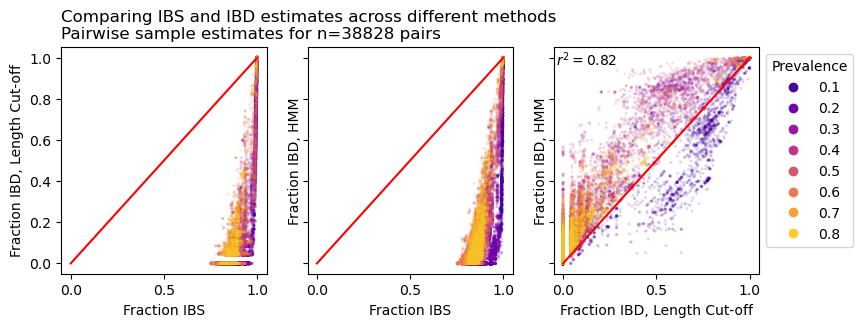

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# Length
ax[0].scatter(x=df["f_ibs"], y=df["f_ibd_lcut"], 
              c=[col_dt[c] for c in df["x_h"]], s=2, alpha=0.1)
ax[0].set_xlabel("Fraction IBS")
ax[0].set_ylabel("Fraction IBD, Length Cut-off")
ax[0].plot([0, 1], [0, 1], color='red')
ax[0].set_title("Comparing IBS and IBD estimates across different methods" +
                "\nPairwise sample estimates for n=%d pairs" % df.shape[0], loc="left")

# HMM
ax[1].scatter(x=df["f_ibs"], y=df["f_ibd_hmm"],
              c=[col_dt[c] for c in df["x_h"]], s=2, alpha=0.1)
ax[1].set_xlabel("Fraction IBS")
ax[1].set_ylabel("Fraction IBD, HMM")
ax[1].plot([0, 1], [0, 1], color='red')


# Length vs. HMM
ax[2].scatter(x=df["f_ibd_lcut"], y=df["f_ibd_hmm"],
              c=[col_dt[c] for c in df["x_h"]], s=2, alpha=0.1)
ax[2].set_xlabel("Fraction IBD, Length Cut-off")
ax[2].set_ylabel("Fraction IBD, HMM")
ax[2].plot([0, 1], [0, 1], color='red')

r2 = metrics.r2_score(df["f_ibd_hmm"], df["f_ibd_lcut"])
ax[2].annotate(xy=(0.01, 0.99), ha="left", va="top", xycoords='axes fraction',
               text="$r^2=$%.02f" % r2)

handles = [Line2D([0], [0], marker='o', lw=0, color=col_dt[c], label="%.1f" % c) for c in x_hs]
ax[2].legend(handles=handles, bbox_to_anchor=(1, 1), title="Prevalence")

if savefigs:
    fig.savefig(os.path.join(output_dir, "ibd-f_pairwise.png"), 
                bbox_inches="tight", pad_inches=0.5)

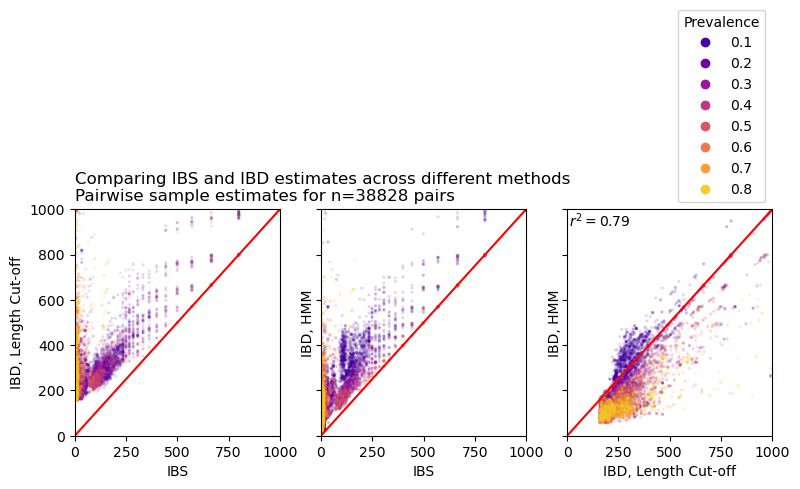

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# Length
ax[0].scatter(x=df["l_ibs"], y=df["l_ibd_lcut"],
              c=[col_dt[c] for c in df["x_h"]], s=2, alpha=0.1)
ax[0].set_xlabel("IBS")
ax[0].set_ylabel("IBD, Length Cut-off")
ax[0].plot([0, nsnps], [0, nsnps], color='red')
ax[0].set_title("Comparing IBS and IBD estimates across different methods" +
                "\nPairwise sample estimates for n=%d pairs" % df.shape[0], loc="left")

# HMM
ax[1].scatter(x=df["l_ibs"], y=df["l_ibd_hmm"],
              c=[col_dt[c] for c in df["x_h"]], s=2, alpha=0.1)
ax[1].set_xlabel("IBS")
ax[1].set_ylabel("IBD, HMM")
ax[1].plot([0, nsnps], [0, nsnps], color='red')


# Length vs. HMM
ax[2].scatter(x=df["l_ibd_lcut"], y=df["l_ibd_hmm"],
              c=[col_dt[c] for c in df["x_h"]], s=2, alpha=0.1)
ax[2].set_xlabel("IBD, Length Cut-off")
ax[2].set_ylabel("IBD, HMM")
ax[2].plot([0, nsnps], [0, nsnps], color='red')
r2 = metrics.r2_score(df.dropna()["l_ibd_lcut"], df.dropna()["l_ibd_hmm"])
ax[2].annotate(xy=(0.01, 0.99), ha="left", va="top", xycoords='axes fraction',
               text="$r^2=$%.02f" % r2)
ax[2].set_xlim((0, 10**3))
ax[2].set_ylim((0, 10**3))

handles = [Line2D([0], [0], marker='o', lw=0, color=col_dt[c], label="%.1f" % c) for c in x_hs]
ax[2].legend(handles=handles, bbox_to_anchor=(1, 1), title="Prevalence")

if savefigs:
    fig.savefig(os.path.join(output_dir, "ibd-l_pairwise.png"), 
                bbox_inches="tight", pad_inches=0.5)

### IBD Distributions

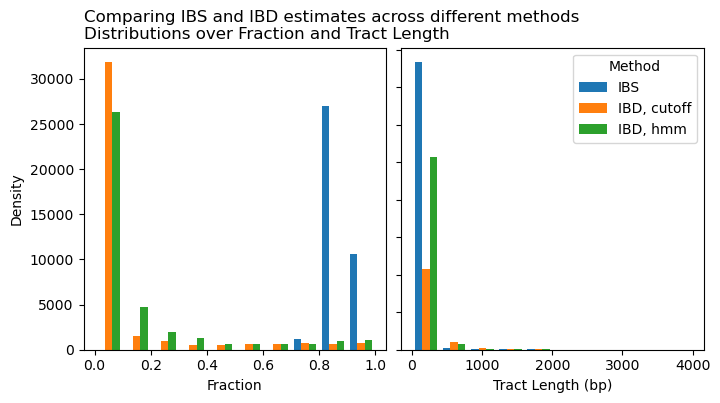

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.subplots_adjust(wspace=0.05)

# Fraction
ax[0].hist([df["f_ibs"], df["f_ibd_lcut"], df["f_ibd_hmm"]], 
           label=["IBS", "IBD_cut", "IBD_hmm"])
#ax[0].set_yticklabels("")
ax[0].set_title("Comparing IBS and IBD estimates across different methods" +
                "\nDistributions over Fraction and Tract Length", loc="left")
ax[0].set_xlabel("Fraction")
ax[0].set_ylabel("Density")

# Length
ax[1].hist([df["l_ibs"], df["l_ibd_lcut"], df["l_ibd_hmm"]], 
           label=["IBS", "IBD, cutoff", "IBD, hmm"])
ax[1].set_xlabel("Tract Length (bp)")
ax[1].legend(title="Method", bbox_to_anchor=(1, 1))
ax[1].label_outer()

if savefigs:
    fig.savefig(os.path.join(output_dir, "ibd-distributions.png"), 
                bbox_inches="tight", pad_inches=0.5)

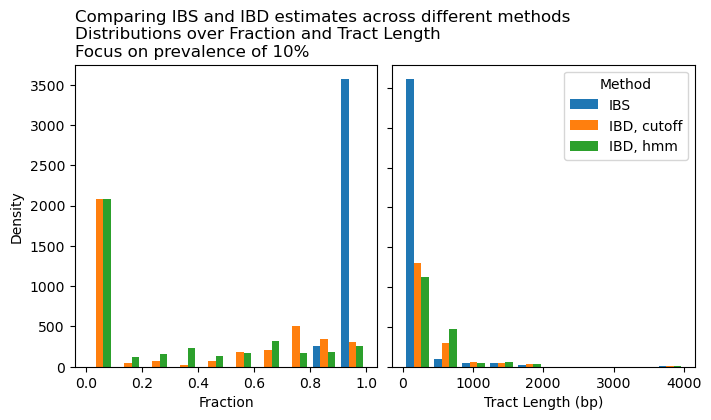

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.subplots_adjust(wspace=0.05)

low_df = df.query("x_h == 0.1")

# Fraction
ax[0].hist([low_df["f_ibs"], low_df["f_ibd_lcut"], low_df["f_ibd_hmm"]], 
           label=["IBS", "IBD_cut", "IBD_hmm"])
#ax[0].set_yticklabels("")
ax[0].set_title("Comparing IBS and IBD estimates across different methods" +
                "\nDistributions over Fraction and Tract Length\nFocus on prevalence of 10%", loc="left")
ax[0].set_xlabel("Fraction")
ax[0].set_ylabel("Density")

# Length
ax[1].hist([low_df["l_ibs"], low_df["l_ibd_lcut"], low_df["l_ibd_hmm"]], 
           label=["IBS", "IBD, cutoff", "IBD, hmm"])
ax[1].set_xlabel("Tract Length (bp)")
ax[1].legend(title="Method", bbox_to_anchor=(1, 1))
ax[1].label_outer()

if savefigs:
    fig.savefig(os.path.join(output_dir, "ibd-distributions-lower-prev.png"), 
                bbox_inches="tight", pad_inches=0.5)

### Relationships with prevalence

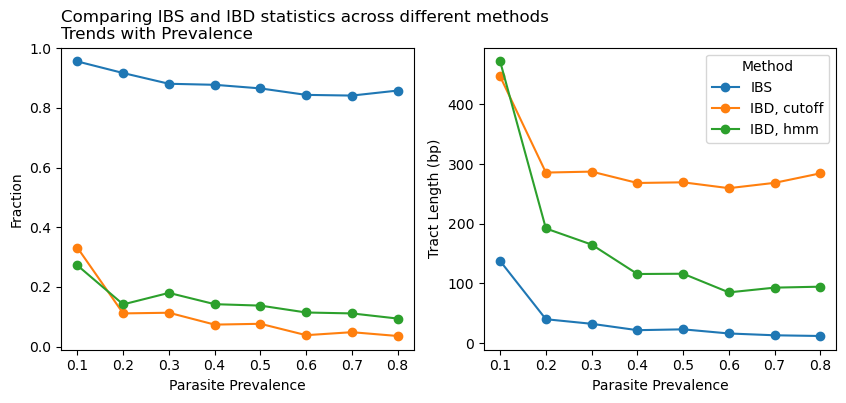

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Fraction
summary_df.plot(x="x_h", y=["f_ibs", "f_ibd_lcut", "f_ibd_hmm"],
                legend=False,
                marker='o', ax=ax[0])
ax[0].set_xlabel("Parasite Prevalence")
ax[0].set_ylabel("Fraction")
ax[0].set_title("Comparing IBS and IBD statistics across different methods"+
                "\nTrends with Prevalence", 
                loc="left")


# Length
summary_df.plot(x="x_h", y=["l_ibs", "l_ibd_lcut", "l_ibd_hmm"],
                label=["IBS", "IBD, cutoff", "IBD, hmm"],
                marker='o', ax=ax[1])
ax[1].set_xlabel("Parasite Prevalence")
ax[1].set_ylabel("Tract Length (bp)")
ax[1].legend(title="Method", bbox_to_anchor=(1, 1))

if savefigs:
    fig.savefig(os.path.join(output_dir, "ibd-trends.png"), 
                bbox_inches="tight", pad_inches=0.5)

- The trend with fraction IBD is similar between the two methods
- The IBD tracks are systematically longer, especially at higher prevalences, for the length cut-off method
    - This makes sense -- the cut-off is based on an expectation, and will truncate the distribution at that expectation
    - Incorporating a flexible minimum length and leveraging information about allele frequencies will allow the positive detection of smaller tracks

## Run-times

In [36]:
%timeit calc_hmm_emission_probabilities(pair, af)

127 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [37]:
%timeit get_ibd_segments_hmm(rho, emiss)

589 µs ± 9.67 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [38]:
%timeit get_ibs_segments(ibs)

3.16 µs ± 45.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


- It's clear the HMM method will be hundreds of times slower.